In [2]:
from pyserini.index.lucene import LuceneIndexReader

class LuceneCustomRecipeReader(LuceneIndexReader):
    """Custom Lucene index reader for recipe search. The only addition is that every time the required
    methods are called, we are going to first process the recipe into the undercores, bacuse by default the 
    Anserini is not supporting full phrase indexing """
    
    def _preprocess_ingredient(self, ingredient):
        return ingredient.replace(' ', '_')
    
    def get_postings_list(self, term, analyzer=None):
        term = self._preprocess_ingredient(term)
        return super().get_postings_list(term, analyzer=analyzer)
    
    def get_term_counts(self, term, analyzer = None):
        term = self._preprocess_ingredient(term)
        return super().get_term_counts(term, analyzer)
    
    def get_term_freq(self, term, docid, analyzer=None):
        term = self._preprocess_ingredient(term)
        return super().get_term_freq(term, docid, analyzer) 
    
recipe_reader = LuceneCustomRecipeReader('indexes/ingredients_pretokenized')


Apr 15, 2025 10:46:05 PM org.apache.lucene.store.MMapDirectory lookupProvider


In [3]:
import itertools

tf_list = []



for term in recipe_reader.terms():
    tf_list.append((term.term, term.df))
    
tf_list = sorted(tf_list, key=lambda x: x[1], reverse=True)


tf_list_base_words = [(ingredient.replace('_', ' '), tf) for ingredient, tf in tf_list]
tf_list_base_words_dict = {ingredient: tf for ingredient, tf in tf_list_base_words}


In [7]:
# do the same thing but use the BERT model 
from sentence_transformers import SentenceTransformer, util
import torch

model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
# encode the ingredients

ingredients = [i[0] for i in tf_list_base_words if i[1] > 1]

ingredients_embeddings = model.encode(ingredients, convert_to_tensor=True)

In [15]:
import numpy as np
import math
from tqdm import tqdm

def build_synonym_dict_numpy(ingredients, embeddings, tf_list_base_words_dict, 
                             alpha=0.5, sim_cutoff=0.6, min_sim=0.5, top_k=100):
    # Convert embeddings to NumPy if necessary.
    if hasattr(embeddings, 'cpu'):
        embeddings = embeddings.cpu().numpy()
    else:
        embeddings = np.array(embeddings)
    
    # Normalize embeddings (each row becomes a unit vector).
    norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
    normalized = embeddings / norms
    
    # Precompute the adjusted term frequency vector.
    log_tf = np.array([math.log(tf_list_base_words_dict.get(ing, 0) + 1) for ing in ingredients],
                      dtype=np.float32)
    adjusted_tf = log_tf ** alpha
    
    synonym_dict = {}
    N = len(ingredients)
    
    # Process each ingredient (row) one at a time.
    for i in tqdm(range(N), desc="Processing recipes"):
        # Compute cosine similarity for ingredient i with all ingredients.
        cosine_row = np.dot(normalized[i], normalized.T)
        
        # Apply cutoffs.
        effective_cosine = cosine_row.copy()
        effective_cosine[effective_cosine < sim_cutoff] = 0.0
        effective_cosine[effective_cosine < min_sim] = 0.0
        
        # Compute weighted score.
        weighted_scores = effective_cosine * adjusted_tf
        weighted_scores[i] = 0.0  # Exclude self
        
        # Extract top_k candidates using argpartition.
        if top_k < len(weighted_scores):
            top_indices_unsorted = np.argpartition(weighted_scores, -top_k)[-top_k:]
        else:
            top_indices_unsorted = np.arange(len(weighted_scores))
        sorted_indices = top_indices_unsorted[np.argsort(weighted_scores[top_indices_unsorted])[::-1]]
        
        # Build candidate tuples: (ingredient, weighted_score, raw_cosine).
        candidates = [(ingredients[j], float(weighted_scores[j]), float(cosine_row[j]))
                      for j in sorted_indices]
        synonym_dict[ingredients[i]] = candidates[:top_k]
    
    return synonym_dict

# Example usage:
synonym_dict = build_synonym_dict_numpy(ingredients, ingredients_embeddings, tf_list_base_words_dict,
                                         alpha=0.2, sim_cutoff=0.6, min_sim=0.5, top_k=100)


Processing recipes: 100%|██████████| 23236/23236 [01:37<00:00, 237.41it/s]


In [18]:
with open("files/other/synonyms.json", "w") as f:
    json.dump(synonym_dict, f)
    

Text(0.5, 0, 'Term Frequency')

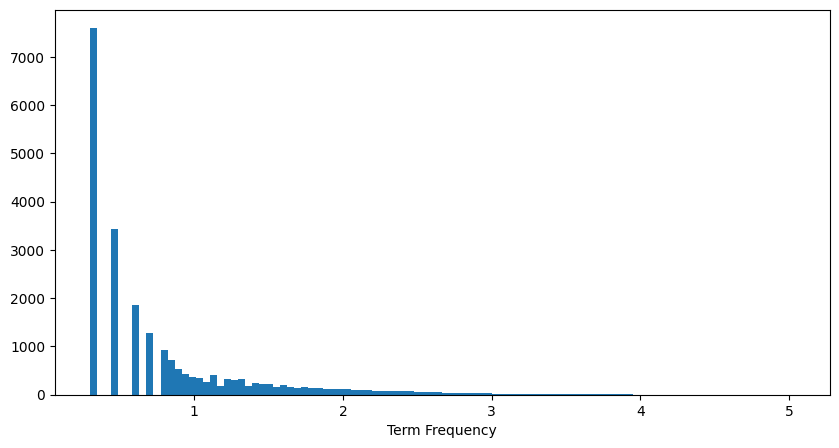

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# plot the distribution of the term frequencies
plt.figure(figsize=(10, 5))
plt.hist([np.log10(tf) for _, tf in tf_list if tf > 1], bins=100)
plt.xlabel('Term Frequency')